In [18]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults, ARIMAResultsWrapper
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna
from optuna import Trial

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import pathlib

import warnings


%matplotlib inline
sns.set_style(style="darkgrid")
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

download_path = r"C:\Users\ahmed\Downloads"
download_path = pathlib.Path(download_path)

device = torch.device(device=("cuda" if torch.cuda.is_available() else "cpu"))

In [2]:
airlines_path = r"D:\Python\time_serise\airline_project\airline_passengers.csv"
df: DataFrame = pd.read_csv(airlines_path)
df

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [3]:
df.isna().sum()[df.isna().sum() > 0]
df.dropna(inplace=True)
df

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


In [4]:
df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df.set_index(keys="Month", inplace=True)

In [5]:
df

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [6]:
df.rename(columns={"Thousands of Passengers" : "thousands_of_passengers"}, inplace=True)

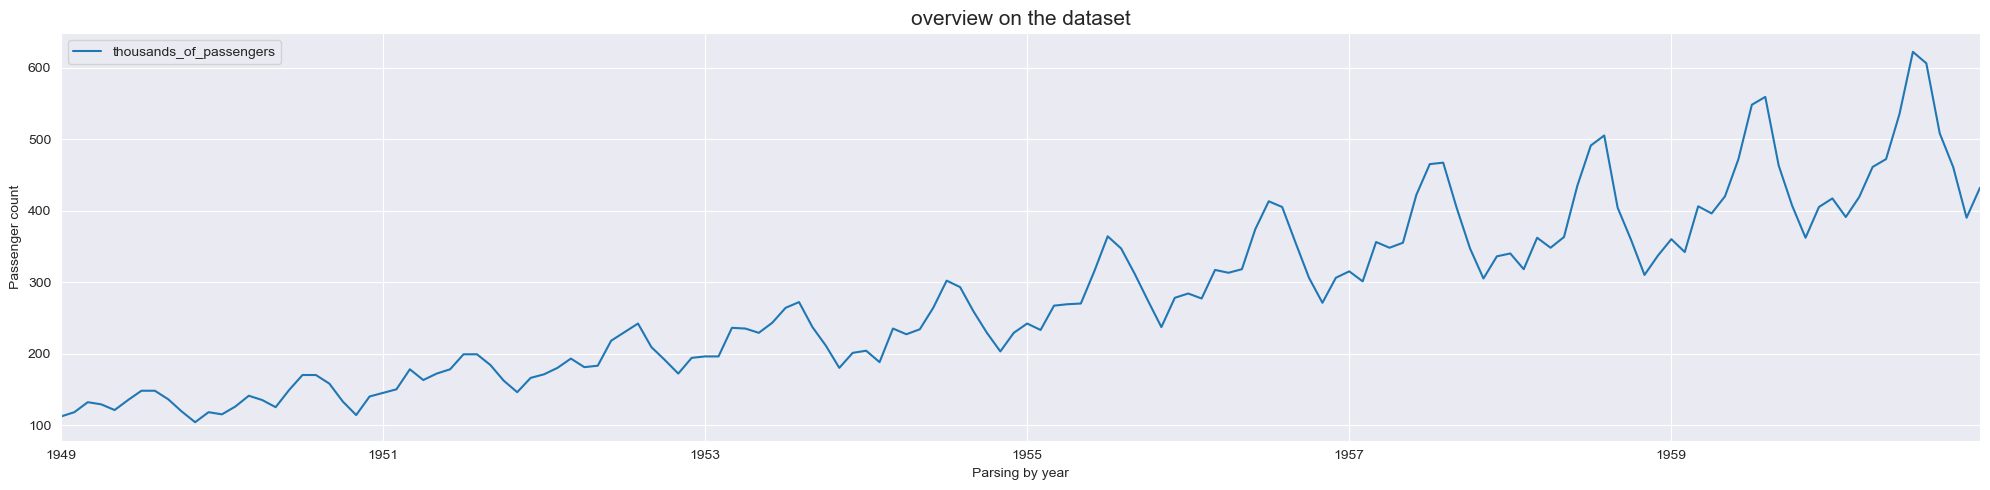

In [7]:
df.plot(figsize=(20, 5))

plt.title("overview on the dataset", fontsize=15)
plt.xlabel("Parsing by year")
plt.ylabel("Passenger count")

plt.tight_layout()
plt.show()

In [8]:
# smoothing the date

df["thousands_of_passengers: 10_ewma"] = df["thousands_of_passengers"].ewm(span=10, adjust=False).mean()
df["thousands_of_passengers: 5_ewma"] = df["thousands_of_passengers"].ewm(span=5, adjust=True).mean()


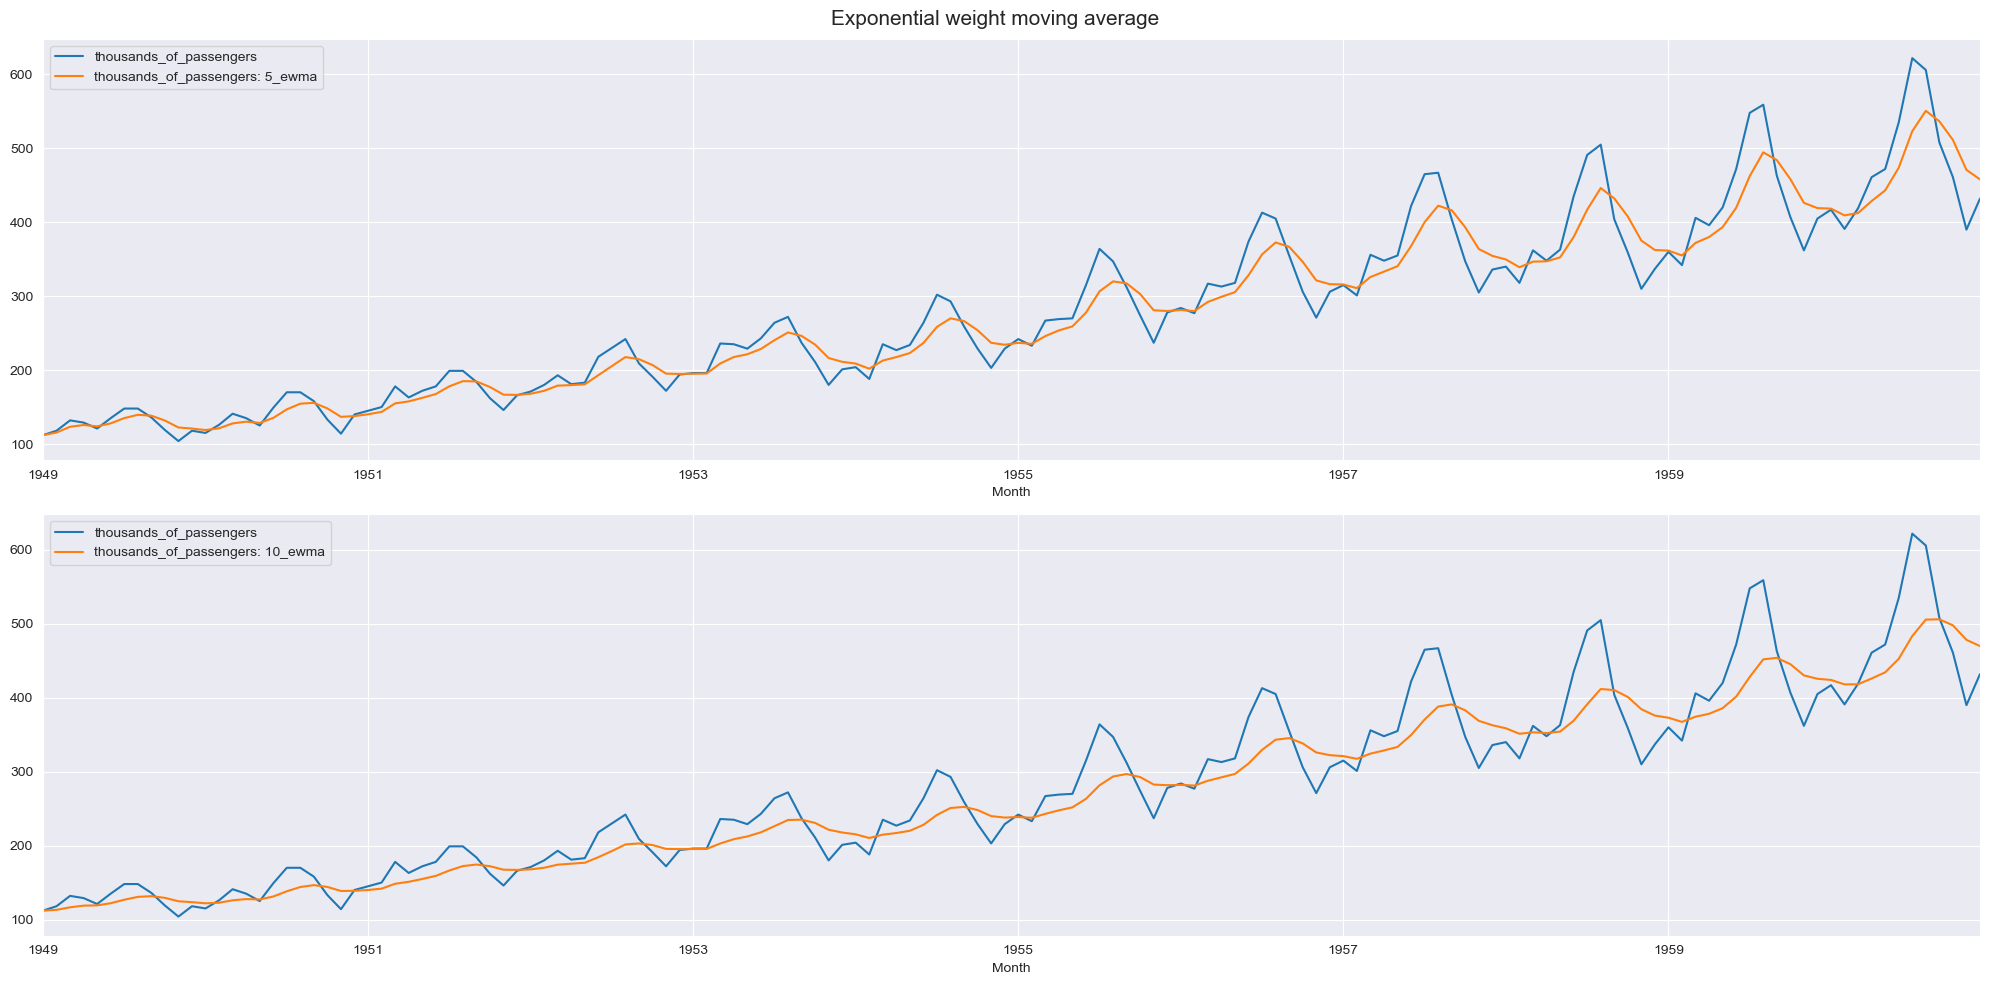

In [9]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(20,10))

df[["thousands_of_passengers", "thousands_of_passengers: 5_ewma"]].plot( ax=ax)
df[["thousands_of_passengers", "thousands_of_passengers: 10_ewma"]].plot( ax=ax2)

plt.suptitle("Exponential weight moving average", fontsize=15)

plt.tight_layout()
plt.show()

In [10]:
df

,thousands_of_passengers,thousands_of_passengers: 10_ewma,thousands_of_passengers: 5_ewma
Month,,,
1949-01-01,112.0,112.000000,112.000000
1949-02-01,118.0,113.090909,115.600000
1949-03-01,132.0,116.528926,123.368421
1949-04-01,129.0,118.796394,125.707692
1949-05-01,121.0,119.197049,123.900474
...,...,...,...
1960-08-01,606.0,505.739233,550.777689
1960-09-01,508.0,506.150282,536.518459
1960-10-01,461.0,497.941140,511.345640


In [11]:
output = adfuller(df["thousands_of_passengers"])
print(f"ADF statistics: {output[0]}")
print(f"p_value => {'fail to reject the null (stationary data):' if output[1] <= 0.05 else 'reject the null (non stationary data):'} {output[1]:.3f}\n")

# apply differencing
df["thousands_of_passengers_first_differencing"] = df["thousands_of_passengers"] - df["thousands_of_passengers"].shift(periods=1)
print("-"*30, "\n", "applying differencing to the dataset\n")

output_diff = adfuller(df["thousands_of_passengers_first_differencing"].dropna())
print(f"ADF statistics: {output_diff[0]}")
print(f"p_value => {'fail to reject the null (stationary data):' if output_diff[1] <= 0.05 else 'reject the null (non stationary data):'} {output_diff[1]:.3f}\n")


df["thousands_of_passengers_first_differencing_2"] = df["thousands_of_passengers"] - df["thousands_of_passengers"].shift(periods=2)
print("-"*30, "\n", "applying differencing to the dataset\n")

output_diff_one = adfuller(df["thousands_of_passengers_first_differencing_2"].dropna())
print(f"ADF statistics: {output_diff_one[0]}")
print(f"p_value => {'fail to reject the null (stationary data):' if output_diff_one[1] <= 0.05 else 'reject the null (non stationary data):'} {output_diff_one[1]:.3f}\n")


df["thousands_of_passengers_first_differencing_12"] = df["thousands_of_passengers"] - df["thousands_of_passengers"].shift(periods=12)
print("-"*30, "\n", "applying differencing to the dataset\n")

output_diff_one = adfuller(df["thousands_of_passengers_first_differencing_12"].dropna())
print(f"ADF statistics: {output_diff_one[0]}")
print(f"p_value => {'fail to reject the null (stationary data):' if output_diff_one[1] <= 0.05 else 'reject the null (non stationary data):'} {output_diff_one[1]:.3f}\n")

ADF statistics: 0.8153688792060511
p_value => reject the null (non stationary data): 0.992

------------------------------ 
 applying differencing to the dataset

ADF statistics: -2.8292668241699874
p_value => reject the null (non stationary data): 0.054

------------------------------ 
 applying differencing to the dataset

ADF statistics: -2.96169513555541
p_value => fail to reject the null (stationary data): 0.039

------------------------------ 
 applying differencing to the dataset

ADF statistics: -3.3830207264924796
p_value => fail to reject the null (stationary data): 0.012



In [12]:
df

,thousands_of_passengers,thousands_of_passengers: 10_ewma,thousands_of_passengers: 5_ewma,thousands_of_passengers_first_differencing,thousands_of_passengers_first_differencing_2,thousands_of_passengers_first_differencing_12
Month,,,,,,
1949-01-01,112.0,112.000000,112.000000,NaN,NaN,NaN
1949-02-01,118.0,113.090909,115.600000,6.0,NaN,NaN
1949-03-01,132.0,116.528926,123.368421,14.0,20.0,NaN
1949-04-01,129.0,118.796394,125.707692,-3.0,11.0,NaN
1949-05-01,121.0,119.197049,123.900474,-8.0,-11.0,NaN
...,...,...,...,...,...,...
1960-08-01,606.0,505.739233,550.777689,-16.0,71.0,47.0
1960-09-01,508.0,506.150282,536.518459,-98.0,-114.0,45.0
1960-10-01,461.0,497.941140,511.345640,-47.0,-145.0,54.0


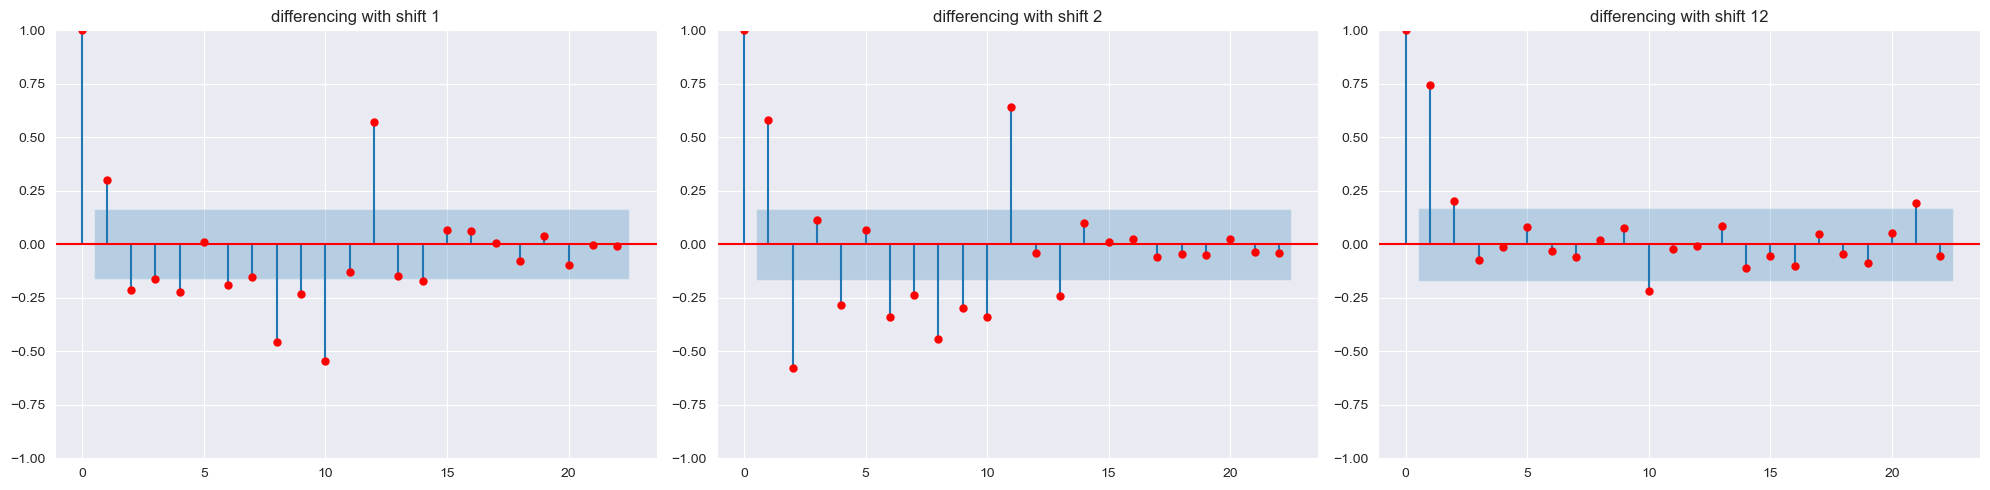

In [13]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(20, 5))

plot_pacf(df["thousands_of_passengers_first_differencing"].dropna(), c="r", ax=ax)
ax.set_title("differencing with shift 1")

plot_pacf(df["thousands_of_passengers_first_differencing_2"].dropna(),c="r", ax=ax2)
ax2.set_title("differencing with shift 2")

plot_pacf(df["thousands_of_passengers_first_differencing_12"].dropna(),c="r", ax=ax3)
ax3.set_title("differencing with shift 12")

plt.tight_layout()
plt.show()


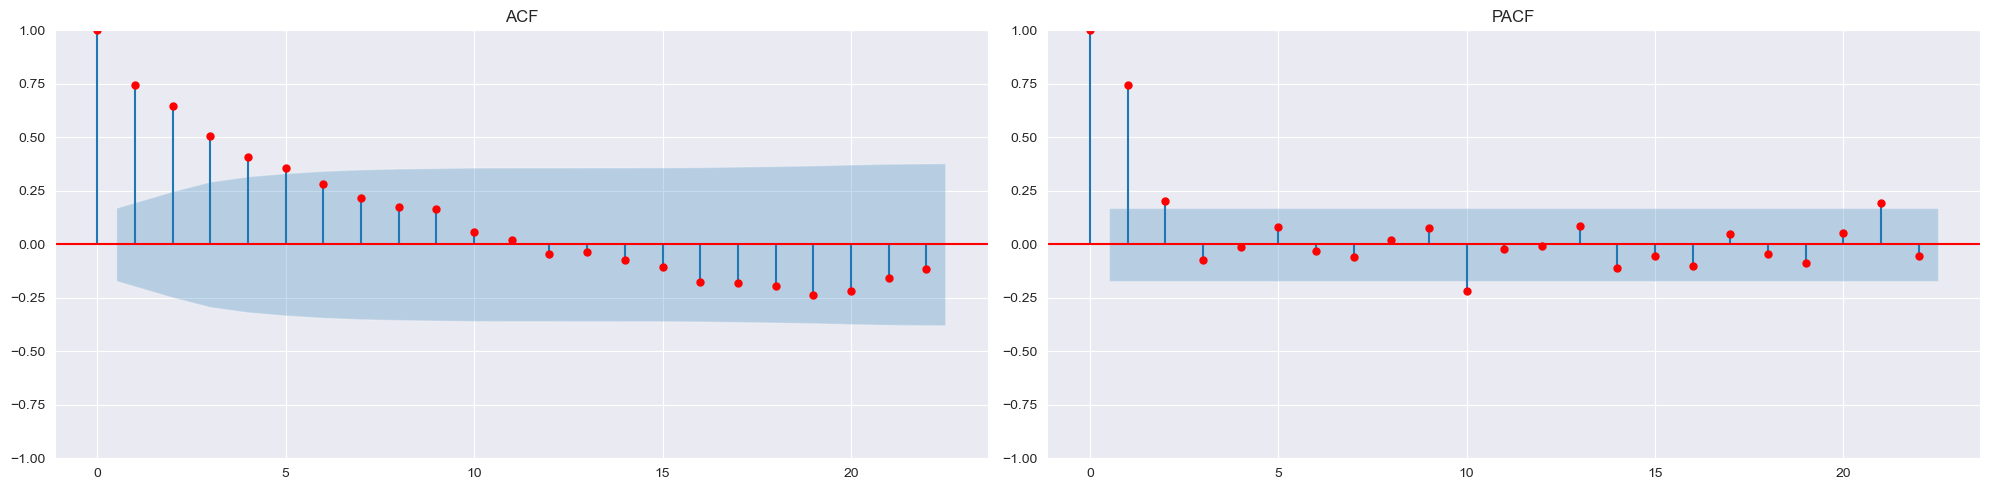

In [19]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(20, 5))

# 12 shift in the passenger 
plot_acf(df["thousands_of_passengers_first_differencing_12"].dropna(), c="r", ax=ax)
ax.set_title("ACF")

plot_pacf(df["thousands_of_passengers_first_differencing_12"].dropna(), c="r", ax=ax2)
ax2.set_title("PACF")

plt.tight_layout()
plt.savefig(download_path / "ACF_vs_PACF_12_shift.png")
plt.show()

In [50]:
# Train data: Before 1957
train_data = df.loc[: "1956-12-01", "thousands_of_passengers"]

# Test data: From 1957 onward
test_data = df.loc["1957-01-01":, "thousands_of_passengers"]

(14, 2, 12)

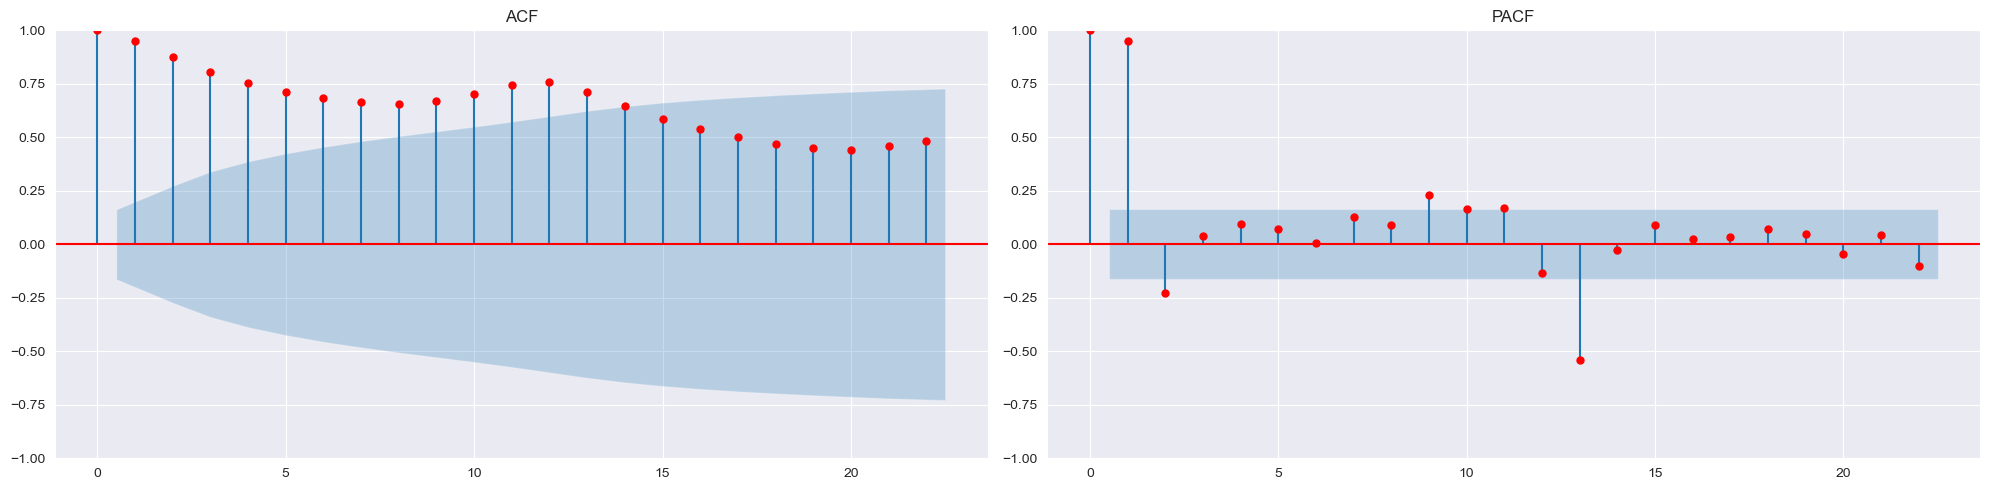

In [25]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(20, 5))

# 12 shift in the passenger 
plot_acf(df["thousands_of_passengers"].dropna(), c="r", ax=ax)
ax.set_title("ACF")

plot_pacf(df["thousands_of_passengers"].dropna(), c="r", ax=ax2)
ax2.set_title("PACF")

plt.tight_layout()
(14, 2, 12)

In [23]:
import plotly.express as px

px.line(df["thousands_of_passengers"])

In [81]:
model = ARIMA(train_data, order=(3,1,2))
result = model.fit()
print(result.summary())

                                  SARIMAX Results                                  
Dep. Variable:     thousands_of_passengers   No. Observations:                   96
Model:                      ARIMA(3, 1, 2)   Log Likelihood                -421.170
Date:                     Tue, 01 Apr 2025   AIC                            854.341
Time:                             18:00:53   BIC                            869.664
Sample:                         01-01-1949   HQIC                           860.533
                              - 12-01-1956                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3       

In [82]:
pred_start = test_data.index[0]
pred_end = test_data.index[-1]


print(f"start prediction: {pred_start}")
print(f"end prediction: {pred_end}")

start prediction: 1957-01-01 00:00:00
end prediction: 1960-12-01 00:00:00


In [83]:
predictions = result.predict(start=pred_start, end=pred_end, typ="levels")
residuals = test_data - predictions
residuals

Month
1957-01-01    -20.594495
1957-02-01    -39.202412
1957-03-01     14.158488
1957-04-01     13.409367
1957-05-01     22.309211
1957-06-01     93.063311
1957-07-01    135.111396
1957-08-01    137.889304
1957-09-01     73.432421
1957-10-01     16.827582
1957-11-01    -25.950242
1957-12-01      5.552983
1958-01-01      9.188681
1958-02-01    -12.416166
1958-03-01     31.336780
1958-04-01     17.574963
1958-05-01     32.385811
1958-06-01    104.531938
1958-07-01    160.401971
1958-08-01    174.501399
1958-09-01     73.417501
1958-10-01     28.486247
1958-11-01    -20.568831
1958-12-01      6.477259
1959-01-01     29.440148
1959-02-01     11.470650
1959-03-01     75.445633
1959-04-01     65.465959
1959-05-01     89.449239
1959-06-01    141.462866
1959-07-01    217.451717
1959-08-01    228.460846
1959-09-01    132.453395
1959-10-01     76.459497
1959-11-01     31.454510
1959-12-01     74.458588
1960-01-01     86.455252
1960-02-01     60.457978
1960-03-01     88.455748
1960-04-01    130.4

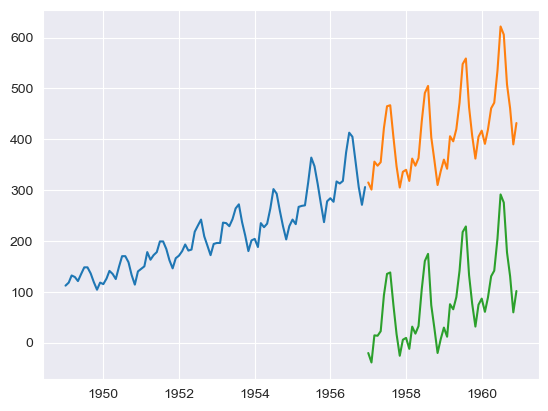

In [86]:
plt.plot(train_data)
plt.plot(test_data)
plt.plot(residuals)
plt.savefig(download_path / "predicitons_arima.png")

In [ ]:
from pmdarima import auto_arima
auto_arima(train_data, seasonal=True)

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(train_data, order=(3,0,5), seasonal_order=(0,1,0,12))
sarimax_model = sarimax_model.fit()
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             thousands_of_passengers   No. Observations:                   96
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -307.958
Date:                             Tue, 01 Apr 2025   AIC                            633.916
Time:                                     18:12:32   BIC                            655.793
Sample:                                 01-01-1949   HQIC                           642.710
                                      - 12-01-1956                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1176      0.258     -0.455      0.649      -0.624       0.388
ar.L2          0.1418      0.243      0.582      0.560      -0.335       0.619
ar.L3          0.9325      0.233      4.003      0.000       0.476       1.389
ma.L1          0.8491      0.251      3.378      0.001       0.356       1.342
ma.L2          0.7537      0.280      2.687      0.007       0.204       1.303
ma.L3         -0.4077      0.195     -2.093      0.036      -0.789      -0.026
ma.L4         -0.2501      0.205     -1.218      0.223      -0.652       0.152
ma.L5         -0.2576      0.166     -1.555      0.120      -0.582       0.067
sigma2        86.2919     15.068      5.727      0.000      56.759     115.825
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.17
Prob(Q):                              0.89   Prob(JB):                         0.21
Heteroskedasticity (H):               1.34   Skew:                             0.48
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
sarimax_predictions = sarimax_model.predict(start=pred_start, end=pred_end)
sarimax_residuals = test_data - sarimax_predictions


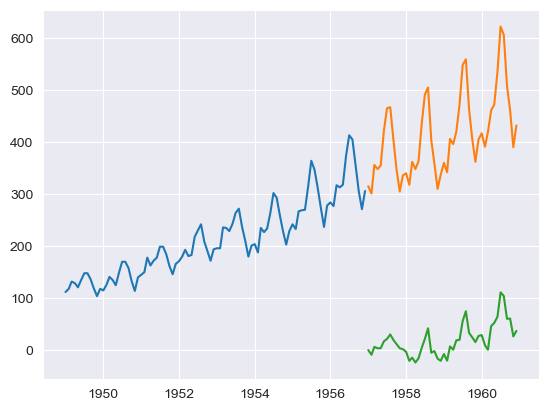

In [95]:
plt.plot(train_data)
plt.plot(test_data)
plt.plot(sarimax_residuals)
plt.savefig(download_path / "predicitons_arima.png")